# A sample stock data analysis notebook
---

#### source: [Machine Learning for Trading on Udacity](https://www.udacity.com/course/machine-learning-for-trading--ud501)

#### reproduced and edited by [Donghan Yang](https://github.com/DonghanYang)

___

## Getting data

In [2]:
%matplotlib notebook
import os
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import math

start = datetime.date(2016, 1, 1)
end = datetime.date.today()
symbols = ['AAPL', 'GOOG', 'IBM', 'GLD']

In [3]:
def get_data(symbols, start, end):
    df = pd.DataFrame(index = pd.date_range(start, end))
    
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = web.DataReader(symbol, "google", start, end)
        df_temp = df_temp['Close']
        df_temp = df_temp.rename(columns={'Close': symbol})
        df[symbol] = df_temp
        df = df.dropna(subset=["SPY"])
    
    return df
df = get_data(symbols, start, end)

## Plotting

In [16]:
def plot_selected(df, columns, start_index, end_index):
    # normalizing stock data
    df = df/df.ix[0,:]
    ax = df.ix[start_index : end_index, columns].plot(title = "Stock Price", fontsize = 12)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    plt.show()
    
    return
# plot_selected(df, ['SPY', 'IBM', 'AAPL', 'GOOG', 'GLD'], '2016-01-01', '2017-06-01')

## Moving Averages and Bollinger Bands

In [17]:
def plotBB(df, ticker, startDate, endDate, window):

    mean = df.mean()
    stats_table = pd.DataFrame({'mean': df.mean(), 'median': df.median(), 'std':df.std()})
    # masking
    stats_table[mean < 200]

    # Bollinger Bands example
    rolling_mean = df[ticker].rolling(window = window).mean()
    rolling_std = df[ticker].rolling(window = window).std()
    upper_band = rolling_mean + 2*rolling_std 
    lower_band = rolling_mean - 2*rolling_std

    # ploting
    plt.figure()
    ax = df[ticker].plot(title="{} - day Bollinger Bands".format(window))
    rolling_mean.plot(ax=ax)
    upper_band.plot(ax=ax)
    lower_band.plot(ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='best')
    plt.legend([ticker, 'rolling mean', 'upper band', 'lower band'])
    plt.show()
    return
# plotBB(df, 'GOOG', '2016-01-01', '2016-03-01', 20)

## Daily return

In [18]:
def dailyReturn(df, tickers, startDate, endDate):
    daily_returns = df.copy()
    # the long way: extract numpy arrays
    # daily_returns[1:] = (df[1:].values / df[:-1].values) - 1

    # the short way: much easier way with Pandas
    daily_returns = (df / df.shift(1)) - 1 

    # replace nan values with 0
    daily_returns.ix[0,:] = 0

    return daily_returns
# dailyReturn(df, ['SPY','AAPL','IBM'], '2016-01-01', '2016-03-01')

# plot
# ax = daily_returns.ix[startDate : endDate, tickers].plot(title = "Daily Return", fontsize = 12)
# ax.set_xlabel("Date")
# ax.set_ylabel("Return")
# plt.show()

## Cumulative Return

In [19]:
def cumulativeReturn(df, tickers, startDate, endDate):
    cum_returns = df.copy()

    cum_returns[1:] = (df[1:] / df.ix[0,:]) - 1
    cum_returns.ix[0,:] = 0
    
    return cum_returns
# cumulativeReturn(df, ['SPY','AAPL','IBM'], '2016-01-01', '2016-03-01')

# plot    
# ax = cum_returns.ix[startDate : endDate, tickers].plot(title = "Cumulative Return", fontsize = 12)
# ax.set_xlabel("Date")
# ax.set_ylabel("Return")
# plt.show()

## Missing Values

<IPython.core.display.Javascript object>


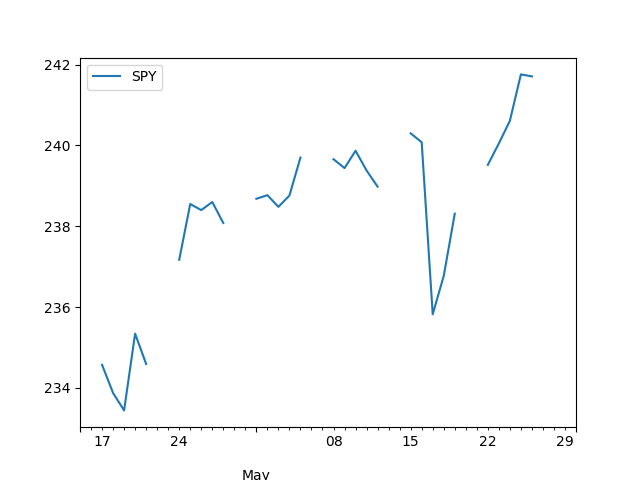

<IPython.core.display.Javascript object>


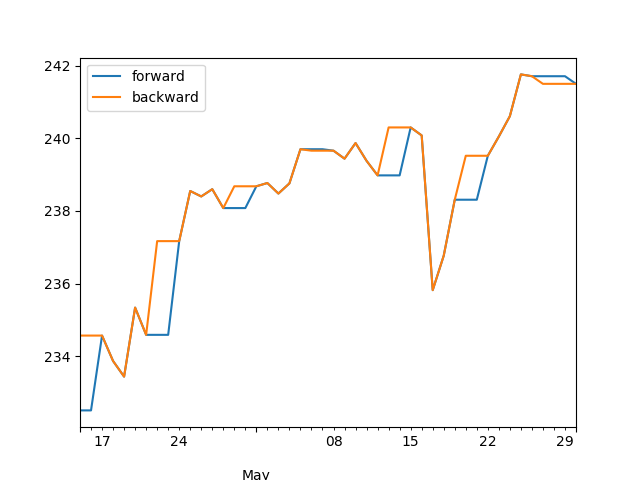

In [20]:
empty_df = pd.DataFrame(index = pd.date_range(start,end))
empty_df = empty_df.join(df, how = 'left')

# notice the gap during weekends
empty_df.ix['2017-04-15':'2017-05-30',['SPY']].plot()

# forward fill the gap
forward = empty_df.copy()
forward.fillna(method='ffill', inplace=True)
ax = forward.ix['2017-04-15':'2017-05-30',['SPY']].plot()

# backward fill
backward = empty_df.copy()
backward.fillna(method='bfill', inplace=True)
backward.ix['2017-04-15':'2017-05-30',['SPY']].plot(ax=ax)
plt.legend(['forward', 'backward'])


## More plotting

<IPython.core.display.Javascript object>


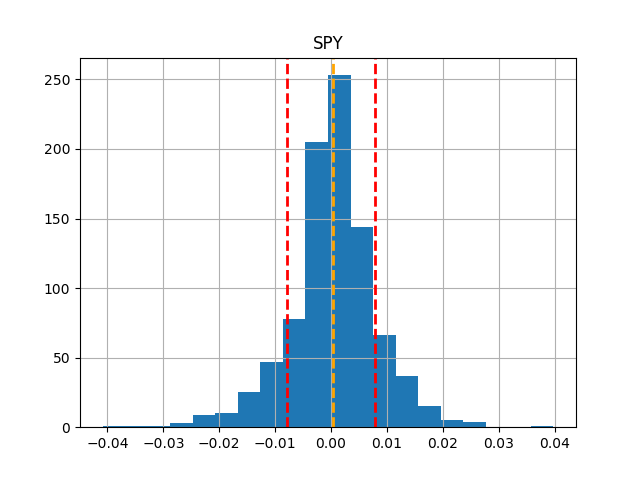

SPY    2.869695
dtype: float64

In [21]:
# barchart of daily return and some summary stats
df = get_data([], "2014-01-01", datetime.date.today())
dR = dailyReturn(df, ['SPY'], "2014-01-01", datetime.date.today())
dR.hist(bins = 20)
mean = dR['SPY'].mean()
std = dR['SPY'].std()
plt.axvline(mean, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.axvline(std, color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(-std, color = 'r', linestyle = 'dashed', linewidth = 2)
plt.show()
dR.kurtosis()

<IPython.core.display.Javascript object>


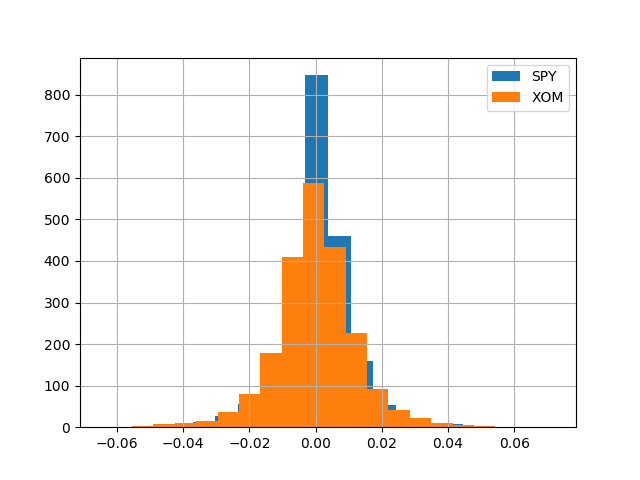

In [22]:
# plot overlapping barcharts 
df = get_data(['SPY', 'GLD', 'XOM'], "2009-01-01", datetime.date.today())
dR = dailyReturn(df, ['SPY','GLD','XOM'], "2009-01-01", datetime.date.today())
plt.figure()
dR['SPY'].hist(bins=20, label='SPY')
dR['XOM'].hist(bins=20, label='XOM')
plt.legend(loc = 'upper right')
plt.show()

<IPython.core.display.Javascript object>


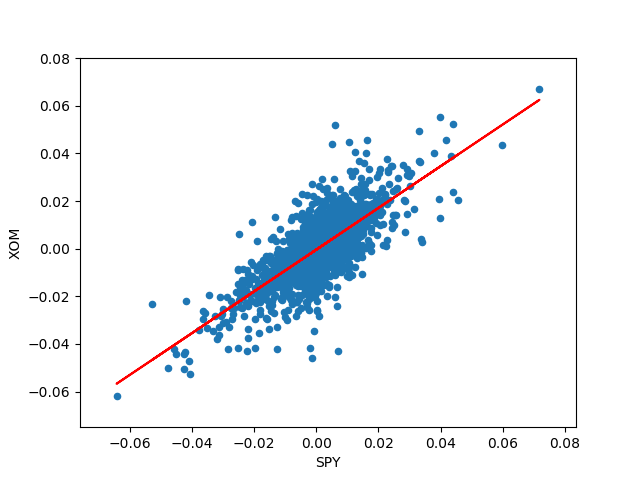

<IPython.core.display.Javascript object>


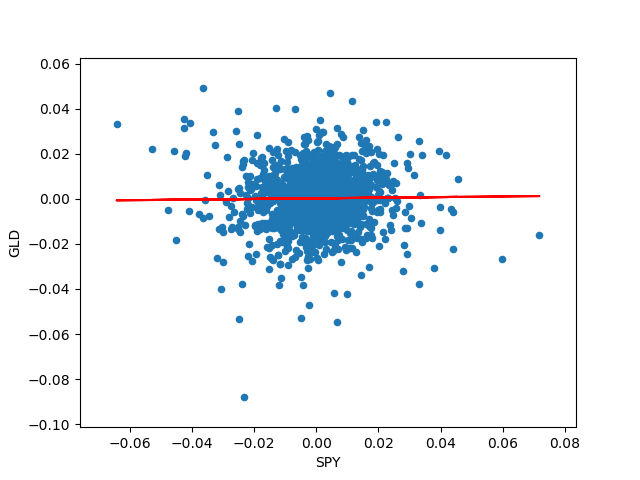

<IPython.core.display.Javascript object>


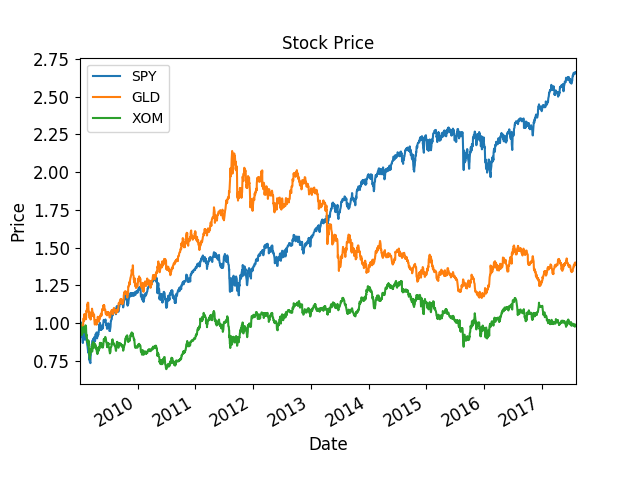

,SPY,GLD,XOM
SPY,1.000000,0.013509,0.747992
GLD,0.013509,1.000000,0.056080
XOM,0.747992,0.056080,1.000000


In [23]:
# pairwise scatter plot
dR.plot(kind = 'scatter', x='SPY',y='XOM')
# beta: coefficient
# alpha: intercept
betaXOM, alphaXOM = np.polyfit(dR['SPY'], dR['XOM'], 1)
plt.plot(dR['SPY'], betaXOM * dR['SPY'] + alphaXOM,'-',color='r')

dR.plot(kind = 'scatter', x='SPY',y='GLD')

betaGLD, alphaGLD = np.polyfit(dR['SPY'], dR['GLD'], 1)
plt.plot(dR['SPY'], betaGLD * dR['SPY'] + alphaGLD,'-',color='r')
plt.show()

plot_selected(df, ['SPY','GLD','XOM'], '2009-01-01', datetime.date.today())

# examine the alpha and beta
dR.corr(method='pearson')

## Portfolio basics

In [29]:
df = get_data(['SPY', 'XOM', 'GOOG', 'GLD'], "2009-01-01", datetime.date.today())

In [59]:
df = df/df.ix[0,:]
allocations = [0.4, 0.4, 0.1, 0.1]
initialValue = 1000000
portfolioValue = (df*allocations*initialValue).sum(axis=1)
daily_returns = (portfolioValue / portfolioValue.shift(1)) - 1 
daily_returns = daily_returns[1:]
cum_returns = portfolioValue[-1] / portfolioValue[0] - 1 

# portfolio evaluation metrics 

print('cumulative returns:', cum_returns)
print('average daily returns:', daily_returns.mean())
print('standard deviation of returns:', daily_returns.std())
print('sharp ratio:', math.sqrt(252)*daily_returns.mean()/daily_returns.std())

# sharp ratio
# risk-free rate 
# use:
# LIBOR
# 3-month treasury bill
# 0%

cumulative returns: 1.17450558715
average daily returns: 0.0004174942025089182
standard deviation of returns: 0.010786415260122738
sharp ratio: 0.614431657049295


## Optimization

X=[ 2.], Y=[ 0.75]
X=[ 2.], Y=[ 0.75]
X=[ 2.00000001], Y=[ 0.75000001]
X=[ 0.99999999], Y=[ 0.75000001]
X=[ 1.5], Y=[ 0.5]
X=[ 1.5], Y=[ 0.5]
X=[ 1.50000001], Y=[ 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5
            Iterations: 2
            Function evaluations: 7
            Gradient evaluations: 2
minima found at:
X=[ 1.5], Y=0.5
X=[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5], Y=[ 1.5   1.31  1.14  0.99  0.86  0.75  0.66  0.59  0.54  0.51  0.5   0.51
  0.54  0.59  0.66  0.75  0.86  0.99  1.14  1.31  1.5 ]


<IPython.core.display.Javascript object>


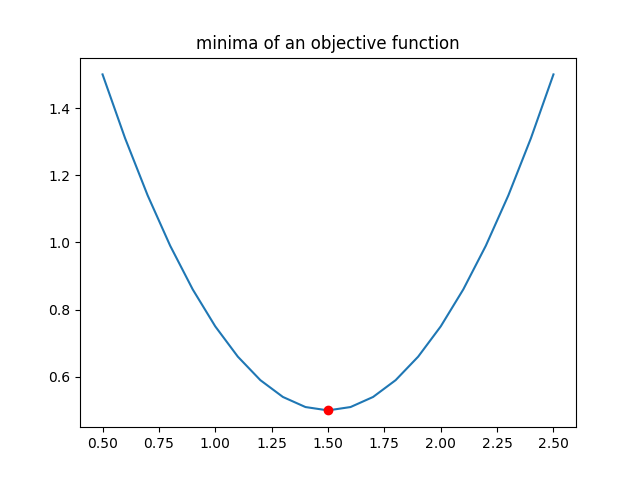

In [73]:
# example of using a minimizer
import scipy.optimize as spo

# define the function that we try to minimize
def f(X):
    Y = (X-1.5)**2+0.5
    print('X={}, Y={}'.format(X,Y))
    return Y

Xguess=2.0
min_res = spo.minimize(f, Xguess, method='SLSQP', options={'disp':True})
print('minima found at:')
print('X={}, Y={}'.format(min_res.x,min_res.fun))

Xplot = np.linspace(0.5,2.5,21)
Yplot = f(Xplot)
plt.plot(Xplot, Yplot)
plt.plot(min_res.x,min_res.fun, 'ro')
plt.title('minima of an objective function')
plt.show()

Original line: C0 = 4.0, C1 = 2.0


<IPython.core.display.Javascript object>


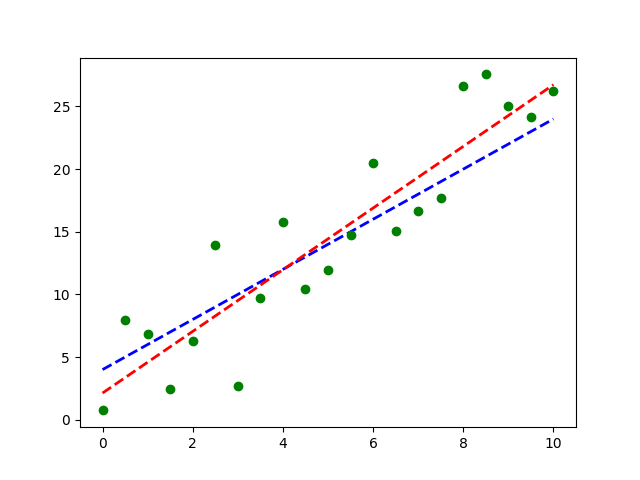

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 232.81276116570615
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
Fitted line: C0 = 2.4609218619496223, C1 = 2.127640504784726


In [102]:
# using optimizer to fit a linear model

np.random.seed(123)

def error(line, data):
    err = np.sum((data[:,1] - (line[0] * data[:,0] + line[1])) ** 2)
    return err

def fit_line(data, error_func):
    # generate initial guess
    l = np.float32([0,np.mean(data[:,1])])
    
    # call optimizer to minimize error function
    result = spo.minimize(error_func, l, args=(data,), 
                          method='SLSQP', options={'disp':True})
    return result.x

l_orig = np.float32([4,2])
print('Original line: C0 = {}, C1 = {}'.format(l_orig[0], l_orig[1]))
Xorig = np.linspace(0,10,21)
Yorig = l_orig[0] + Xorig * l_orig[1]
plt.figure()
plt.plot(Xorig, Yorig, 'b--', linewidth=2, label='original line')
plt.show()

# generate noisy points
noiseSigma = 3
noise = np.random.normal(0, noiseSigma, Yorig.shape)
data = np.asarray([Xorig, Yorig + noise]).T
plt.plot(data[:,0], data[:,1], 'go', label='Data points')

# fit a line
l_fit = fit_line(data, error)
print('Fitted line: C0 = {}, C1 = {}'.format(l_fit[0],l_fit[1]))
plt.plot(data[:,0], l_fit[0] * data[:,0] + l_fit[1], 'r--', 
         linewidth=2)

Original line: C0 = 4.0, C1 = 2.0, C2 = 3.0


<IPython.core.display.Javascript object>


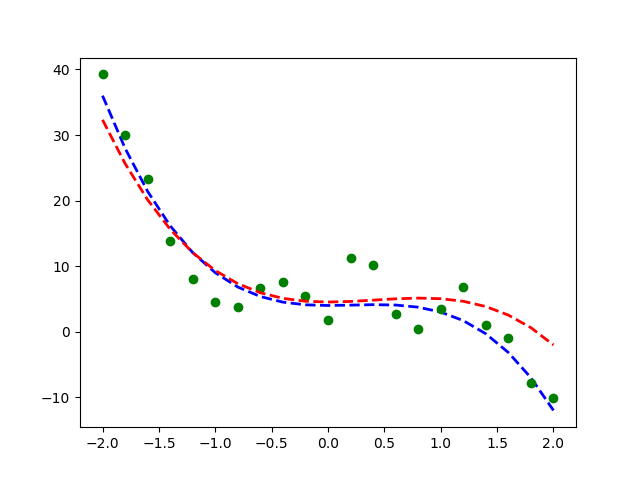

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 177.16999957661054
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Fitted line: C0 = 4.529163637105012, C1 = 2.655300569053845, C2 = 2.1462552539701534


In [108]:
def error_poly(C, data):
    # sum of squared errors
    err = np.sum((data[:,1] - np.polyval(C, data[:,0]))**2)
    return err

def fit_poly(data, error_func, degree=3):
    Cguess = np.poly1d(np.ones(degree+1, dtype=np.float32))
    result = spo.minimize(error_func, Cguess, args=(data,), method='SLSQP', options={'disp':True})
    return np.poly1d(result.x)


l_orig = np.float32([4,2,3])
print('Original line: C0 = {}, C1 = {}, C2 = {}'.format(l_orig[0], l_orig[1], l_orig[2]))
Xorig = np.linspace(-2,2,21)
Yorig = l_orig[0] + (Xorig**2) * l_orig[1] - (Xorig**3) * l_orig[2] 
plt.figure()
plt.plot(Xorig, Yorig, 'b--', linewidth=2, label='original line')
plt.show()

# generate noisy points
noiseSigma = 4
noise = np.random.normal(0, noiseSigma, Yorig.shape)
data = np.asarray([Xorig, Yorig + noise]).T
plt.plot(data[:,0], data[:,1], 'go', label='Data points')

# fit a line
l_fit = fit_poly(data, error_poly)
print('Fitted line: C0 = {}, C1 = {}, C2 = {}'.format(l_fit[0],l_fit[1],l_fit[2]))
plt.plot(data[:,0], l_fit[0] + (data[:,0]**2)*l_fit[1] - l_fit[2]*(data[:,0]**3), 'r--', linewidth=2)

##  Portfolio optimization example

In [18]:
import scipy.optimize as spo
import math

# prepare the stocks price
df = get_data(['SPY', 'XOM', 'GOOG', 'GLD', 'AAPL', 'IBM'], "2017-01-01", datetime.date.today())
df = df[['XOM', 'GOOG', 'GLD', 'AAPL', 'IBM']]
df = df/df.ix[0,:]

# initial value of the total asset
initialValue = 1000000

def f(allocations):
    portfolioValue = (df*allocations*initialValue).sum(axis=1)
    daily_returns = (portfolioValue / portfolioValue.shift(1)) - 1 
    daily_returns = daily_returns[1:]
    sharp = (-math.sqrt(252))*daily_returns.mean()/daily_returns.std()
    return sharp

# weights between 0 to 1, no leverage, no shorting
bounds = [(0,1) for i in range(5)]    
constraints = ({'type':'eq', 'fun': lambda allocations: sum(allocations)-1})   # Sum of weights = 100%

# initial guess
Xguess=[0.25,0.25,0.25,0.25,0.25]

optimized = spo.minimize(f, Xguess, method='SLSQP', constraints=constraints, bounds=bounds, options={'disp':True})

# result, no rebalancing
np.around(optimized.x, decimals=3)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.4014490046265644
            Iterations: 9
            Function evaluations: 69
            Gradient evaluations: 9


array([ 0.   ,  0.117,  0.47 ,  0.413,  0.   ])